## Programming Environment

In [1]:
# 3rd Party
import tensorflow as tf
import numpy as np
# Python STL
from typing import List,Tuple,Dict
import time
import datetime
import glob
import os
import pdb
import json

In [2]:
from ssd import SSD512_VGG16
from ssd.data import *
from common.checkpoints import save_checkpoint

## Data

In [3]:
def ssd_tfrecords(records_dir, num_parallel_calls=8):
    record_paths = glob.glob(os.path.join(records_dir, "*.tfrecord"))
    dataset = tf.data.TFRecordDataset(record_paths, num_parallel_reads=num_parallel_calls)
    
    dataset = dataset.map(deserialize_ssd_example,
                         deterministic=False,
                         num_parallel_calls=num_parallel_calls)
    return dataset
    

In [4]:
records_root = "./dota_sports_records"
coco_root = "./dota_sports_data"
train_dir = os.path.join(records_root, "train")
valid_dir = os.path.join(records_root, "validation")

## Training Setup

In [5]:
import datetime
def cur_date_string():
    return datetime.datetime.now().strftime("%m-%d-%y-%H:%M:%S")

In [6]:
def make_metric_dict(names, types = None):
    d = dict()
    for (i, name) in enumerate(names):
        t = types[i] if types else tf.keras.metrics.Sum
        d[name] = t(name, dtype=tf.float32)
    return d

def prepend_namespace(d, prefix):
    return {f"{prefix}/{k}":v for (k,v) in d.items()}

def metric2scalar_dict(m, prefix = None, v_func = None, reset_states=True):
    scalars = dict()
    for (k, v) in m.items():
        value = v.result()
        if v_func: value = v_func(value)
        scalars[k] = value
    if reset_states:
        for (k,v) in m.items():
            v.reset_states()
    if prefix: scalars = prepend_namespace(scalars, prefix)
    return scalars

def update_metric_dict(m, u):
    for k in m:
        m[k](u[k])

def write_scalars(writer, scalar_dict, step):
    with writer.as_default():
        for (k, v) in scalar_dict.items():
            tf.summary.scalar(k, v, step=step)
    writer.flush()

In [7]:
def train_epoch(model,optimizer, dataset,
                epoch_index : int,
                batch_index : tf.Variable,
                log_freq : int = 250,
                writer = None):
    
    log = lambda msg: print(f"[{cur_date_string()}]: {msg}")
    to_fine_tune = [v for v in model.trainable_variables]
    
    epoch_metrics = make_metric_dict(["Localization", "Confidence", "WeightedTotal"])
    era_metrics   = make_metric_dict(["Localization", "Confidence", "WeightedTotal"])

    epoch_samples = 0
    era_samples = 0
    log("Started new training epoch")
    
    batch_start = batch_index.numpy()
    for batch in dataset:
        batch_index.assign_add(1)

        epoch_samples += len(batch["image"])
        era_samples += len(batch["image"])
        keys = ["cls_targets", "cls_weights", "reg_targets", "reg_weights", "matched"]
        images, shapes = model.preprocess(batch["image"])
        model.provide_groundtruth_direct(**{k:batch[k] for k in keys})
        with tf.GradientTape() as tape:
            prediction_dict = model.predict(images, shapes)
            loss_dict = model.loss(prediction_dict)
        gradients = tape.gradient(loss_dict["WeightedTotal"], to_fine_tune)
        optimizer.apply_gradients( zip(gradients, to_fine_tune) )
        update_metric_dict(epoch_metrics, loss_dict)
        update_metric_dict(era_metrics, loss_dict)
        
        if (batch_index - batch_start) % log_freq == 0:
            log(f"Completed {batch_index - batch_start} batches")
            l_dict = metric2scalar_dict(era_metrics,
                                        prefix       = f"Loss/Train/Last_{log_freq}_Batches",
                                        v_func      = lambda v: v / era_samples,
                                        reset_states = True)
            write_scalars(writer, l_dict, step=batch_index)

    l_dict = metric2scalar_dict(epoch_metrics,
                                prefix       = f"Loss/Train/Epoch",
                                v_func      = lambda v: v / epoch_samples,
                                reset_states = True)
    write_scalars(writer, l_dict, step=epoch_index)
    
#     for (_, met) in era_metrics.items():
#         met.reset_states()

In [8]:
def validation_loss(model, batch_size = 2):
    metrics = make_metric_dict(["Localization", "Confidence", "WeightedTotal"])
    n_samples = 0
    dataset = ssd_tfrecords(valid_dir)
    dataset = dataset.batch(batch_size)
    for batch in dataset:
        images, shapes = model.preprocess(batch["image"])
        prediction_dict = model.predict(images, shapes)
        keys = ["cls_targets", "cls_weights", "reg_targets", "reg_weights", "matched"]
        model.provide_groundtruth_direct(**{k:batch[k] for k in keys})
        loss_dict = model.loss(prediction_dict)
        update_metric_dict(metrics, loss_dict)
        n_samples += len(batch["image"])
    scalars = metric2scalar_dict(metrics, v_func = lambda v: v / n_samples, reset_states=True)
    return scalars


In [9]:
checkpoints_root = "./checkpoints"

In [39]:
alpha = 1.
nms_redund_threshold = 0.45
top_k_per_class=100

# desired_categories = ['plane','baseball-diamond','bridge','ground-track-field','small-vehicle','large-vehicle', \
#                       'ship','tennis-court','basketball-court', 'storage-tank','soccer-ball-field', \
#                       'roundabout','harbor','swimming-pool','helicopter']

desired_categories = ['baseball-diamond','ground-track-field','tennis-court','soccer-ball-field']

with tf.device("/device:GPU:2"):
    weights_path = "/data/pretrained_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    model = SSD512_VGG16.from_scratch(len(desired_categories),
                                    weights_path,
                                   loc_weight = alpha,
                                   nms_redund_threshold=nms_redund_threshold,
                                   top_k_per_class=top_k_per_class)

In [40]:
with tf.device("/device:GPU:2"):
    patience = 5

    vars_dict = {
        "waited": tf.Variable(0, trainable=False, shape=(), dtype=tf.int64),
        "epoch_index"      : tf.Variable(0, trainable=False, shape=(), dtype=tf.int64),
        "best_model_index" : tf.Variable(-1, trainable=False, shape=(), dtype=tf.int64),
        "batch_index"      : tf.Variable(0, trainable=False, shape=(), dtype=tf.int64),
        "best_validation_loss": tf.Variable(np.inf, trainable=False, shape=(), dtype=tf.float32),
        "model"            : model.model,
        "optimizer"        : tf.keras.optimizers.Adam(learning_rate=1e-5)
    }
    
    checkpoint = tf.train.Checkpoint(**vars_dict)
    checkpoints_root = os.path.relpath("./checkpoints")
    os.makedirs(checkpoints_root, exist_ok=True)
    manager = tf.train.CheckpointManager(checkpoint, directory=checkpoints_root,max_to_keep=patience + 1)

In [41]:
latest_ckpt = tf.train.latest_checkpoint(checkpoints_root)
checkpoint.restore(latest_ckpt)

## Training

In [23]:
model.loc_weight = 1./5.
print(epoch_index, model.loc_weight)

<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=36> 0.2


In [25]:
model.loc_weight = 1./10.
print(epoch_index, model.loc_weight)

<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=37> 0.1


In [27]:
model.loc_weight = 1./100.
print(epoch_index, model.loc_weight)

<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=38> 0.01


In [51]:
model.loc_weight = 0
print(epoch_index, model.loc_weight)

<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=39> 0


In [52]:
epoch_index = vars_dict["epoch_index"]
batch_index = vars_dict["batch_index"]
optimizer = vars_dict["optimizer"]
best_val_loss = vars_dict["best_validation_loss"]
waited = vars_dict["waited"]

batch_size = 2
num_epochs = 5
log_freq = 100 // batch_size
shuffle_buffer_size = 1000
with tf.device("/device:GPU:2"):
    writer = tf.summary.create_file_writer(os.path.join("./tb"))
    for _ in range(num_epochs):
        epoch_index.assign_add(1)
        dataset = ssd_tfrecords(train_dir)
        dataset = dataset.shuffle(seed=int(time.time()), buffer_size=shuffle_buffer_size)
        dataset = dataset.batch(batch_size)

        train_epoch(model,optimizer,dataset,
                                  epoch_index=vars_dict["epoch_index"],
                                  batch_index=vars_dict["batch_index"],
                                  log_freq=log_freq,
                                writer=writer)

        
        loss_dict = validation_loss(model, batch_size=batch_size)
        
        val_loss = loss_dict["WeightedTotal"]
        if val_loss < best_val_loss:
            print(f"New best validation_loss: {val_loss}")
            vars_dict["best_model_index"].assign(epoch_index)
            best_val_loss.assign(val_loss)
            waited.assign(0)
        else:
            waited.assign_add(1)
            
        loss_dict = prepend_namespace(loss_dict, "Loss/Validation")
        write_scalars(writer, loss_dict, step=epoch_index)

        manager.save(checkpoint_number=epoch_index)
        if waited >= patience: break


[11-16-20-13:30:57]: Started new training epoch
[11-16-20-13:31:04]: Completed 50 batches
[11-16-20-13:31:11]: Completed 100 batches
[11-16-20-13:31:18]: Completed 150 batches
New best validation_loss: 14.332449913024902
[11-16-20-13:31:22]: Started new training epoch
[11-16-20-13:31:29]: Completed 50 batches
[11-16-20-13:31:36]: Completed 100 batches
[11-16-20-13:31:43]: Completed 150 batches
[11-16-20-13:31:47]: Started new training epoch
[11-16-20-13:31:54]: Completed 50 batches
[11-16-20-13:32:02]: Completed 100 batches
[11-16-20-13:32:09]: Completed 150 batches
[11-16-20-13:32:12]: Started new training epoch
[11-16-20-13:32:20]: Completed 50 batches
[11-16-20-13:32:27]: Completed 100 batches
[11-16-20-13:32:34]: Completed 150 batches
[11-16-20-13:32:38]: Started new training epoch
[11-16-20-13:32:45]: Completed 50 batches
[11-16-20-13:32:52]: Completed 100 batches
[11-16-20-13:32:59]: Completed 150 batches


## Evaluation

In [48]:
from common.eval import coco_eval
model.nms_redund_threshold = .45
with tf.device("/device:GPU:2"):
    metrics_dict = coco_eval(model,
              coco_root + '/annotations/validation.json',
              coco_root + '/validation/images/',
            min_coverage=.3,
            desired_categories=desired_categories,
            win_set=(1024,1024,512,512))

creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.56s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.040
 Average Recall     (AR) @[ IoU=0

In [50]:
from common.eval import coco_eval
model.nms_redund_threshold = .45
with tf.device("/device:GPU:2"):
    metrics_dict = coco_eval(model,
              coco_root + '/annotations/train.json',
              coco_root + '/train/images/',
            min_coverage=.3,
            desired_categories=desired_categories,
            win_set=(1024,1024,512,512))

creating index...
index created!
Loading and preparing results...
DONE (t=0.40s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.06s).
Accumulating evaluation results...
DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.023
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Recall     (AR) @[ IoU=0

## Visualization

In [22]:
from evaluate.detect import run_inference
(valid_images_dict, predicted_boxes_list, predicted_classes_list, predicted_scores_list) = \
    run_inference(valid_images_np, valid_images_dict, label_id_offsets, model)

In [29]:
%matplotlib inline

In [30]:
from utils.plot import plot_detections
p = lambda i: plot_detections(valid_images_np[i],
                    predicted_boxes_list[i],
                    predicted_classes_list[i],
                    predicted_scores_list[i],
                    category_index
)


In [38]:
ind = 6
predicted_scores_list[ind][:10], predicted_classes_list[ind][:10], predicted_boxes_list[ind][:10]

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 [2, 8, 8, 8, 8, 8, 8, 8, 8, 8],
 array([[ 8.6525812e+00, -1.3629997e+02,  8.6525812e+00,  1.5862135e+02],
        [ 7.5076122e+00,           -inf,  7.5076361e+00,            inf],
        [-2.0273113e+00, -1.0510982e+20, -2.0273113e+00,  1.0510982e+20],
        [-5.7268852e-01, -2.8768096e+00, -5.7268852e-01,  3.4018016e+00],
        [-7.0127583e+00, -1.3674053e+25, -7.0127583e+00,  1.3674053e+25],
        [-6.8889966e+00, -2.6289136e+32, -6.8863797e+00,  2.6289136e+32],
        [-2.6986549e+00, -1.4450738e+27, -2.6986372e+00,  1.4450738e+27],
        [ 3.2443714e+00, -2.4442234e+29,  3.2443714e+00,  2.4442234e+29],
        [          -inf,  2.0204113e+00,            inf,  2.2382677e+00],
        [-2.4266973e+00,  6.8288617e+00, -2.4266973e+00,  6.8288617e+00]],
       dtype=float32))

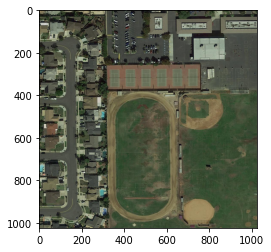

In [37]:
p(6)